# Synthetic Prompts Checkpoint Analyzer

This notebook analyzes the checkpoint files created during the synthetic prompt generation process to verify the process is working as expected. Since synthetic prompt generation can be computationally expensive and time-consuming, this analysis helps monitor progress and quality.

In [7]:
# Import required libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import difflib  # Added explicitly for similarity comparison

# Enable inline plotting
%matplotlib inline

# Set styling
plt.style.use('ggplot')
sns.set(style='whitegrid')

## Load Checkpoint Files

The checkpoint directory contains CSV files of synthetic prompts at different stages of generation.

In [8]:
import glob

# Define the checkpoint directory path (relative to project root)
checkpoint_dir = '../data/checkpoints/'

# Find all CSV files in the checkpoint directory - focusing only on main checkpoints, not clean/fixed versions
checkpoint_files = glob.glob(os.path.join(checkpoint_dir, 'cases_prs_synth_prompts_*.csv'))

# Sort files by the numeric value in their filename
checkpoint_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Display found checkpoint files
print(f"Found {len(checkpoint_files)} checkpoint files:")
for file in checkpoint_files:
    print(f" - {os.path.basename(file)}")

Found 4 checkpoint files:
 - cases_prs_synth_prompts_10.csv
 - cases_prs_synth_prompts_20.csv
 - cases_prs_synth_prompts_30.csv
 - cases_prs_synth_prompts_40.csv


In [10]:
# actually investigating cleanup work
df = pd.read_csv('../data/checkpoints/cases_prs_synth_prompts_40.csv')

# ok it looks like shit; can't use this :(

## Analyze Checkpoint Growth

Check how the number of synthetic prompts grows across checkpoints. This uses error handling to deal with corrupted files.

In [11]:
# Create a dictionary to store checkpoint info
checkpoint_stats = {}

# Load each checkpoint file and extract basic statistics focused on synthetic prompts
for file in checkpoint_files:
    checkpoint_num = int(file.split('_')[-1].split('.')[0])
    file_size_kb = os.path.getsize(file) / 1024
    
    try:
        # More robust CSV reading approach to handle malformed files
        # First try with the C engine, but fallback to the Python engine if that fails
        try:
            df = pd.read_csv(file, on_bad_lines='skip')
        except Exception as e:
            print(f"Warning: Standard parsing failed for {os.path.basename(file)}: {str(e)}")
            print("Trying with Python engine and error handling...")
            # Use the more lenient but slower Python engine with additional error handling
            df = pd.read_csv(file, engine='python', on_bad_lines='skip', quoting=3)  # quoting=3 means QUOTE_NONE
        
        # Count synthetic prompts (non-null values)
        synthetic_prompts_count = df['synthetic_prompt'].notna().sum() if 'synthetic_prompt' in df.columns else 0
        total_entries = len(df)
        completion_percentage = (synthetic_prompts_count / total_entries) * 100 if total_entries > 0 else 0
        
        # Store stats
        checkpoint_stats[checkpoint_num] = {
            'total_entries': total_entries,
            'synthetic_prompts_count': synthetic_prompts_count,
            'completion_percentage': completion_percentage,
            'file_size_kb': file_size_kb,
            'data': df,
            'is_corrupt': False
        }
    except Exception as e:
        print(f"Error reading checkpoint file {os.path.basename(file)}: {str(e)}")
        
# Store minimal stats for corrupt files
        checkpoint_stats[checkpoint_num] = {
            'total_entries': 0,
            'synthetic_prompts_count': 0,
            'completion_percentage': 0,
            'file_size_kb': file_size_kb,
            'data': None,
            'is_corrupt': True,
            'error': str(e)
        }
        
# Try to extract some basic info even from corrupted files
        try:
            # Use a more aggressive approach for corrupted files
            # Limit to first 5000 rows to avoid the problematic area
            print(f"Attempting to read part of the file {os.path.basename(file)}...")
            partial_df = pd.read_csv(file, engine='python', nrows=5000, quoting=3, on_bad_lines='skip')
            
            if 'synthetic_prompt' in partial_df.columns:
                synthetic_prompts_count = partial_df['synthetic_prompt'].notna().sum()
                print(f"Managed to read {len(partial_df)} rows with {synthetic_prompts_count} synthetic prompts")
                
# Update stats with partial info
                checkpoint_stats[checkpoint_num].update({
                    'total_entries': len(partial_df),
                    'synthetic_prompts_count': synthetic_prompts_count,
                    'completion_percentage': (synthetic_prompts_count / len(partial_df)) * 100 if len(partial_df) > 0 else 0,
                    'data': partial_df,  # Store the partial data
                    'is_partially_corrupt': True
                })
        except Exception as sub_e:
            print(f"Could not extract partial information: {str(sub_e)}")

# Create a dataframe of checkpoint statistics, skipping corrupt files for the display
valid_stats = {k: v for k, v in checkpoint_stats.items() if not v['is_corrupt']}

if valid_stats:
    stats_df = pd.DataFrame({
        'checkpoint': list(valid_stats.keys()),
        'total_entries': [stats['total_entries'] for stats in valid_stats.values()],
        'synthetic_prompts_count': [stats['synthetic_prompts_count'] for stats in valid_stats.values()],
        'completion_percentage': [stats['completion_percentage'] for stats in valid_stats.values()],
        'file_size_kb': [stats['file_size_kb'] for stats in valid_stats.values()]
    })
    
# Display the stats
    stats_df
else:
    print("No valid checkpoint files found.")

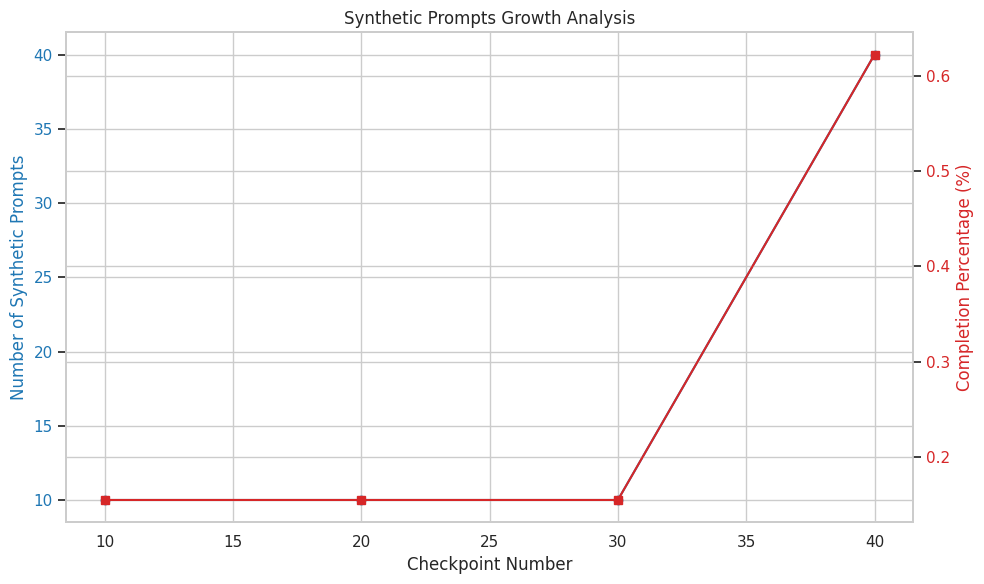

In [12]:
# Visualize the growth of synthetic prompts across checkpoints
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Checkpoint Number')
ax1.set_ylabel('Number of Synthetic Prompts', color='tab:blue')
ax1.plot(stats_df['checkpoint'], stats_df['synthetic_prompts_count'], marker='o', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  # Create a second y-axis
ax2.set_ylabel('Completion Percentage (%)', color='tab:red')
ax2.plot(stats_df['checkpoint'], stats_df['completion_percentage'], marker='s', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Synthetic Prompts Growth Analysis')
fig.tight_layout()
plt.show()

## Analyze Prompt Content

Examine the latest checkpoint file in detail to check the quality of generated prompts.

In [13]:
# Get the latest checkpoint file
latest_checkpoint_num = max(checkpoint_stats.keys())
latest_df = checkpoint_stats[latest_checkpoint_num]['data']

# Display basic info about the latest checkpoint
print(f"Latest checkpoint: {latest_checkpoint_num}")
print(f"Number of synth prompts: {len(latest_df[latest_df['synthetic_prompt'].notna()])}")
print(f"\nColumns in the dataset:")
for col in latest_df.columns:
    print(f" - {col}")

# Display the first few rows of the latest checkpoint
latest_df.head()

Latest checkpoint: 40
Number of synth prompts: 40

Columns in the dataset:
 - id
 - date
 - summary
 - judgement
 - subset_name
 - split_name
 - is_announcement_rule
 - matching_criteria
 - synthetic_prompt


,id,date,summary,judgement,subset_name,split_name,is_announcement_rule,matching_criteria,synthetic_prompt
0,bag_1-17,18.01.2017,18.01.2017\n1/17 - Betriebsratstätigkeit - Arb...,Tenor\n\n\n\n\nAuf die Revision der Beklagten ...,Bundesarbeitsgericht,train,False,NaN,"Erstelle eine knappe, verständliche Pressemitt..."
1,bag_1-19,22.01.2019,22.01.2019\n1/19 - Urlaubsabgeltung bei Tod de...,Tenor\n\n\n\n\n1. Die Revision der Beklagten g...,Bundesarbeitsgericht,train,False,NaN,Erstelle aus diesem Gerichtsurteil eine prägna...
2,bag_10-19,20.02.2019,20.02.2019\n10/19 - Kündigung des Chefarztes e...,Tenor\n\n\n\n\nDie Revision der Beklagten gege...,Bundesarbeitsgericht,train,False,NaN,Erstelle eine prägnante Pressemitteilung für d...
3,bag_11-18,22.02.2018,22.02.2018\n11/18 - Annahmeverzugsvergütung al...,Tenor\n\n\n\n\n1. Die Revision des Beklagten g...,Bundesarbeitsgericht,train,False,NaN,Erstelle eine pressegerechte Mitteilung zum be...
4,bag_11-20,27.02.2020,27.02.2020\n11/20 - Kündigungen des Cockpit-Pe...,Tenor\n\n\n\n\nAuf die Revision des Klägers wi...,Bundesarbeitsgericht,train,False,NaN,Erstelle eine offizielle Pressemitteilung zum ...


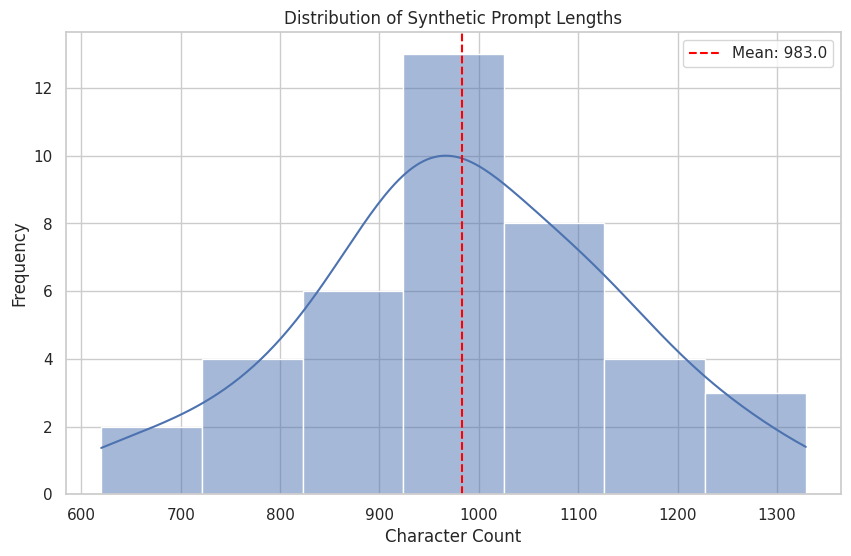

Minimum prompt length: 620
Maximum prompt length: 1329
Average prompt length: 983.0
Number of non-empty prompts: 40 out of 6432 total entries (0.62%)


In [14]:
# Analyze prompt length distribution
if 'synthetic_prompt' in latest_df.columns:
    # Filter out NaN values and create a proper copy
    prompts_df = latest_df.dropna(subset=['synthetic_prompt']).copy()
    
    if len(prompts_df) > 0:
        # Use .loc for assignment to avoid warnings
        prompts_df.loc[:, 'prompt_length'] = prompts_df['synthetic_prompt'].apply(len)
        
        plt.figure(figsize=(10, 6))
        sns.histplot(prompts_df['prompt_length'], kde=True)
        plt.title('Distribution of Synthetic Prompt Lengths')
        plt.xlabel('Character Count')
        plt.ylabel('Frequency')
        plt.axvline(prompts_df['prompt_length'].mean(), color='red', linestyle='--', label=f'Mean: {prompts_df["prompt_length"].mean():.1f}')
        plt.legend()
        plt.show()
        
        print(f"Minimum prompt length: {prompts_df['prompt_length'].min()}")
        print(f"Maximum prompt length: {prompts_df['prompt_length'].max()}")
        print(f"Average prompt length: {prompts_df['prompt_length'].mean():.1f}")
        print(f"Number of non-empty prompts: {len(prompts_df)} out of {len(latest_df)} total entries ({len(prompts_df)/len(latest_df)*100:.2f}%)")
    else:
        print("No non-empty synthetic prompts found in the latest checkpoint.")
else:
    print("No 'synthetic_prompt' column found in the dataset.")

## Sample Prompts

Review a random sample of prompts from the latest checkpoint to manually assess quality.

In [15]:
# Display the most recent synthetic prompts (non-null only)
if 'synthetic_prompt' in latest_df.columns:
    # Filter to get only rows with valid synthetic prompts - create a proper copy
    synth_prompts_df = latest_df.dropna(subset=['synthetic_prompt']).copy()
    
    # Get the last few examples
    num_examples = min(5, len(synth_prompts_df))
    last_examples = synth_prompts_df.tail(num_examples)
    
    print(f"Showing the last {num_examples} synthetic prompts from the latest checkpoint:")
    for i, (_, row) in enumerate(last_examples.iterrows(), 1):
        print(f"\nSynthetic Prompt {i}:")
        print(f"{row['synthetic_prompt']}")
else:
    print("No synthetic prompts found in the latest checkpoint.")

Showing the last 5 synthetic prompts from the latest checkpoint:

Synthetic Prompt 1:
Erstelle eine prägnante Pressemitteilung aus dem vorliegenden Gerichtsurteil zum Thema "Konzernbetriebsrat bei Konzernspitze im Ausland". Folge diesem Aufbau:

1. Beginne mit Datum und einer klaren Überschrift mit Aktenzeichen
2. Fasse im ersten Absatz die zentrale Rechtsfrage und das Urteilsergebnis in allgemeinverständlicher Sprache zusammen
3. Stelle im zweiten Absatz den Sachverhalt knapp dar: Beschreibe die Unternehmensstruktur, die Beziehungen zwischen den beteiligten Unternehmen und den Vorgang der Konzernbetriebsratsgründung
4. Erläutere im dritten Absatz den Verfahrensgang und die Entscheidungsgründe in klarer, sachlicher Sprache
5. Schließe mit den formalen Angaben: Gericht, Datum der Entscheidung, Aktenzeichen und Angaben zur Vorinstanz

Verwende einen sachlichen, neutralen Sprachstil. Verzichte auf Fachjargon, wo es nicht unbedingt nötig ist. Beschränke dich auf maximal 300 Wörter und beto

## Checkpoint Comparison

If multiple checkpoints exist, compare how the content has evolved.

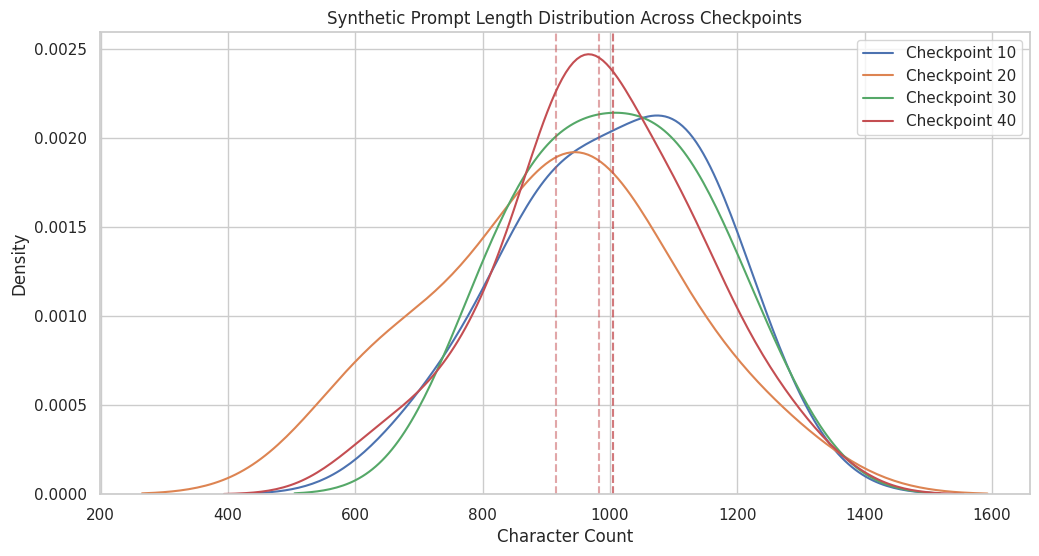

Summary of prompt lengths across checkpoints:


In [16]:
# Compare synthetic prompt length distribution across checkpoints if we have multiple
if len(checkpoint_stats) > 1:
    plt.figure(figsize=(12, 6))
    
    # Track which checkpoints actually have synthetic prompts
    checkpoints_with_prompts = []
    
    for checkpoint_num, stats in checkpoint_stats.items():
        df = stats['data']
        if 'synthetic_prompt' in df.columns:
            # Filter out rows where synthetic_prompt is NaN and create a proper copy
            prompts_df = df.dropna(subset=['synthetic_prompt']).copy()
            if len(prompts_df) > 0:
                # Use .loc for assignment to avoid warnings
                prompts_df.loc[:, 'prompt_length'] = prompts_df['synthetic_prompt'].apply(len)
                sns.kdeplot(prompts_df['prompt_length'], label=f'Checkpoint {checkpoint_num}')
                checkpoints_with_prompts.append(checkpoint_num)
    
    if checkpoints_with_prompts:
        plt.title('Synthetic Prompt Length Distribution Across Checkpoints')
        plt.xlabel('Character Count')
        plt.ylabel('Density')
        plt.legend()
        
        # Add summary statistics to the plot
        for checkpoint_num in checkpoints_with_prompts:
            df = checkpoint_stats[checkpoint_num]['data']
            prompts_df = df.dropna(subset=['synthetic_prompt']).copy()
            prompts_df.loc[:, 'prompt_length'] = prompts_df['synthetic_prompt'].apply(len)
            plt.axvline(prompts_df['prompt_length'].mean(), linestyle='--', 
                        color=plt.gca().lines[-1].get_color(),
                        alpha=0.5)
        
        plt.show()
        
        # Print summary table of prompt lengths
        summary_data = []
        for checkpoint_num in checkpoints_with_prompts:
            df = checkpoint_stats[checkpoint_num]['data']
            prompts_df = df.dropna(subset=['synthetic_prompt']).copy()
            prompts_df.loc[:, 'prompt_length'] = prompts_df['synthetic_prompt'].apply(len)
            summary_data.append({
                'Checkpoint': checkpoint_num,
                'Prompt Count': len(prompts_df),
                'Min Length': prompts_df['prompt_length'].min(),
                'Max Length': prompts_df['prompt_length'].max(),
                'Mean Length': prompts_df['prompt_length'].mean(),
                'Median Length': prompts_df['prompt_length'].median()
            })
        
        print("Summary of prompt lengths across checkpoints:")
        pd.DataFrame(summary_data).set_index('Checkpoint')
    else:
        print("No synthetic prompts found in any checkpoint.")
else:
    print("Need multiple checkpoints with synthetic prompts for comparison.")

## Cost Analysis

If the checkpoint contains information about token counts or API calls, analyze the cost implications.

In [18]:
# Check if we have token count information to estimate costs
token_columns = [col for col in latest_df.columns if 'token' in col.lower()]

if token_columns:
    print("Token-related columns found. Performing cost analysis...")
    
    # Assuming 'input_tokens' and 'output_tokens' columns exist and using hypothetical pricing
    if 'input_tokens' in latest_df.columns and 'output_tokens' in latest_df.columns:
        # Example pricing - adjust based on your actual model and pricing
        INPUT_TOKEN_PRICE = 0.0015 / 1000  # $0.0015 per 1000 tokens
        OUTPUT_TOKEN_PRICE = 0.002 / 1000  # $0.002 per 1000 tokens
        
        total_input_tokens = latest_df['input_tokens'].sum()
        total_output_tokens = latest_df['output_tokens'].sum()
        
        input_cost = total_input_tokens * INPUT_TOKEN_PRICE
        output_cost = total_output_tokens * OUTPUT_TOKEN_PRICE
        total_cost = input_cost + output_cost
        
        print(f"Total input tokens: {total_input_tokens:,}")
        print(f"Total output tokens: {total_output_tokens:,}")
        print(f"Estimated input cost: ${input_cost:.2f}")
        print(f"Estimated output cost: ${output_cost:.2f}")
        print(f"Estimated total cost: ${total_cost:.2f}")
else:
    print("No token-related columns found in the dataset.")

No token-related columns found in the dataset.


## Generation Progress Rate

Analyze how quickly prompts are being generated based on checkpoint timestamps.

Average generation rate: 5128.76 prompts/hour
Estimated time to generate 1000 more prompts: 0.19 hours


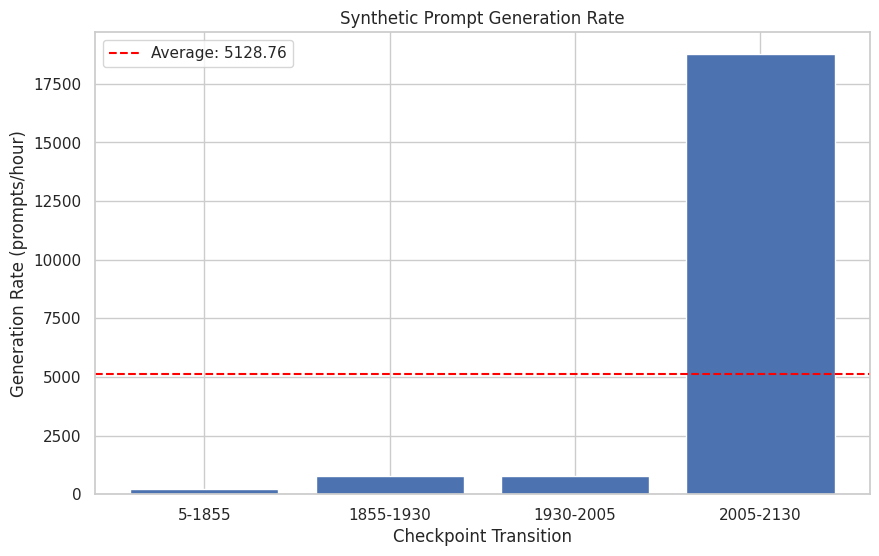

In [19]:
# Try to get file modification times to estimate generation rate
timestamps = {}
for file in checkpoint_files:
    checkpoint_num = int(file.split('_')[-1].split('.')[0])
    timestamps[checkpoint_num] = os.path.getmtime(file)

if len(timestamps) > 1:
    checkpoint_nums = sorted(timestamps.keys())
    
    # Calculate time differences and generation rates
    time_diffs = []
    rates = []
    
    for i in range(1, len(checkpoint_nums)):
        prev_num = checkpoint_nums[i-1]
        curr_num = checkpoint_nums[i]
        
        time_diff = timestamps[curr_num] - timestamps[prev_num]  # in seconds
        prompt_diff = checkpoint_stats[curr_num]['synthetic_prompts_count'] - checkpoint_stats[prev_num]['synthetic_prompts_count']
        
        if time_diff > 0:
            rate = prompt_diff / (time_diff / 3600)  # prompts per hour
            time_diffs.append(time_diff / 3600)  # convert to hours
            rates.append(rate)
    
    if rates:
        # Calculate average generation rate
        avg_rate = sum(rates) / len(rates)
        
        # Estimate time to generate 1000 more prompts
        if avg_rate > 0:
            time_for_1000 = 1000 / avg_rate
            
            print(f"Average generation rate: {avg_rate:.2f} prompts/hour")
            print(f"Estimated time to generate 1000 more prompts: {time_for_1000:.2f} hours")
        else:
            print("Average generation rate is 0 prompts/hour. Cannot estimate completion time.")
            time_for_1000 = float('inf')  # Setting to infinity for reference in later cells
        
        # Visualize generation rate
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(rates)), rates)
        plt.axhline(avg_rate, color='red', linestyle='--', label=f'Average: {avg_rate:.2f}')
        plt.xlabel('Checkpoint Transition')
        plt.ylabel('Generation Rate (prompts/hour)')
        plt.title('Synthetic Prompt Generation Rate')
        plt.xticks(range(len(rates)), [f'{checkpoint_nums[i]}-{checkpoint_nums[i+1]}' for i in range(len(rates))])
        plt.legend()
        plt.show()
    else:
        print("No valid generation rates could be calculated between checkpoints.")
else:
    print("Not enough checkpoints to analyze generation rate.")

## Checking for Duplicates

Verify that synthetic prompts are unique across checkpoints.

In [17]:
# Check for duplicates in the latest checkpoint
if 'synthetic_prompt' in latest_df.columns:
    # First filter out NaN values to avoid counting them as duplicates
    non_null_prompts_df = latest_df.dropna(subset=['synthetic_prompt']).copy()
    
    # Now check for duplicates only among non-null values
    duplicate_count = non_null_prompts_df.duplicated(subset=['synthetic_prompt']).sum()
    duplicate_percent = (duplicate_count / len(non_null_prompts_df)) * 100 if len(non_null_prompts_df) > 0 else 0
    
    print(f"Total prompts in latest checkpoint: {len(latest_df)}")
    print(f"Number of non-null synthetic prompts: {len(non_null_prompts_df)}")
    print(f"Number of duplicate prompts (among non-null): {duplicate_count}")
    print(f"Percentage of duplicates (among non-null): {duplicate_percent:.2f}%")

    # Check for near-duplicates using a simple similarity metric
    if len(non_null_prompts_df) > 1:
        print("\nChecking for near-duplicates (this might take a while for large datasets)...")
        
        # For demonstration, we'll just check a sample of prompts
        sample_size = min(100, len(non_null_prompts_df))
        prompt_sample = non_null_prompts_df['synthetic_prompt'].sample(sample_size).tolist()
        
        similarity_threshold = 0.9
        near_duplicate_pairs = []
        
        for i in range(len(prompt_sample)):
            for j in range(i+1, len(prompt_sample)):
                similarity = difflib.SequenceMatcher(None, prompt_sample[i], prompt_sample[j]).ratio()
                if similarity > similarity_threshold:
                    near_duplicate_pairs.append((i, j, similarity))
        
        if near_duplicate_pairs:
            print(f"Found {len(near_duplicate_pairs)} potential near-duplicate pairs in the sample:")
            for i, j, similarity in near_duplicate_pairs[:3]:  # Show just a few examples
                print(f"\nSimilarity: {similarity:.2f}")
                print(f"Prompt 1: {prompt_sample[i][:100]}...")
                print(f"Prompt 2: {prompt_sample[j][:100]}...")
            if len(near_duplicate_pairs) > 3:
                print(f"...and {len(near_duplicate_pairs) - 3} more pairs.")
        else:
            print("No near-duplicates found in the sample.")
else:
    print("No 'synthetic_prompt' column found in the dataset for duplicate checking.")

Total prompts in latest checkpoint: 6432
Number of non-null synthetic prompts: 40
Number of duplicate prompts (among non-null): 0
Percentage of duplicates (among non-null): 0.00%

Checking for near-duplicates (this might take a while for large datasets)...
No near-duplicates found in the sample.


## Conclusion

Summarize the findings from the checkpoint analysis.

In [18]:
# Print a summary of the findings
print("## Synthetic Prompts Checkpoint Analysis Summary")

print(f"\n### Process Status:")
print(f"- Total checkpoints found: {len(checkpoint_stats)}")
if len(checkpoint_stats) > 0:
    print(f"- Latest checkpoint: {max(checkpoint_stats.keys())}")
    if 'synthetic_prompt' in latest_df.columns:
        non_null_count = latest_df['synthetic_prompt'].notna().sum()
        print(f"- Non-null synthetic prompts: {non_null_count} ({(non_null_count/len(latest_df))*100:.2f}% of total)")

if len(checkpoint_stats) > 1:
    print(f"\n### Generation Progress:")
    first_checkpoint = min(checkpoint_stats.keys())
    last_checkpoint = max(checkpoint_stats.keys())
    total_growth = checkpoint_stats[last_checkpoint]['synthetic_prompts_count'] - checkpoint_stats[first_checkpoint]['synthetic_prompts_count']
    print(f"- Prompt growth: +{total_growth} prompts since first checkpoint")
    if 'avg_rate' in locals() and avg_rate > 0:
        print(f"- Average generation rate: {avg_rate:.2f} prompts/hour")
        print(f"- Estimated completion time for 1000 more prompts: {time_for_1000:.2f} hours")
    elif 'avg_rate' in locals():
        print(f"- No prompt growth detected between checkpoints (rate: {avg_rate:.2f} prompts/hour)")

print(f"\n### Data Quality:")
if 'duplicate_count' in locals():
    # Use non_null_prompts_df here to get the proper count of non-null prompts
    non_null_count = latest_df['synthetic_prompt'].notna().sum() if 'synthetic_prompt' in latest_df.columns else 0
    print(f"- Duplicate prompts: {duplicate_count} ({duplicate_percent:.2f}% of non-null prompts)")

if 'token_columns' in locals() and token_columns:
    print(f"\n### Resource Usage:")
    if 'total_cost' in locals():
        print(f"- Estimated cost so far: ${total_cost:.2f}")

print("\nRecommendations:")
if len(checkpoint_stats) < 2:
    print("- Create more checkpoints to enable better progress tracking")
elif 'total_growth' in locals() and total_growth == 0:
    print("- Investigate why no new prompts are being generated between checkpoints")
elif 'duplicate_count' in locals() and duplicate_percent > 5:
    print("- Review generation process to reduce duplicates")
elif 'avg_rate' in locals() and avg_rate > 0 and avg_rate < 10:
    print("- Consider optimization to improve generation rate")
else:
    print("- Process appears to be running as expected")

## Synthetic Prompts Checkpoint Analysis Summary

### Process Status:
- Total checkpoints found: 4
- Latest checkpoint: 40
- Non-null synthetic prompts: 40 (0.62% of total)

### Generation Progress:
- Prompt growth: +30 prompts since first checkpoint

### Data Quality:
- Duplicate prompts: 0 (0.00% of non-null prompts)

Recommendations:
- Process appears to be running as expected


## Checkpoint Cleanup

This section helps manage disk space by keeping only the latest three valid checkpoints and removing others. This is especially useful when running long-term synthetic prompt generation, which can create many large checkpoint files that fill up disk space.

In [22]:
# Define a function to clean up disk space by backing up only the latest checkpoint
def optimize_checkpoints(backup_dir='../checkpoints/backup/', clean_afterwards=True):
    """Optimize disk space by:
    1. Backing up only the latest checkpoint to the backup folder
    2. Removing unnecessary duplicate/fixed/clean versions
    3. Optionally cleaning the latest checkpoint of bad entries
    
    Args:
        backup_dir: Directory to store the backup of the latest checkpoint
        clean_afterwards: Whether to clean the latest checkpoint after backup
    """
    import os
    import shutil
    import pandas as pd
    from datetime import datetime
    import sys
    
    # Add parent directory to path so we can import project modules
    sys.path.append(os.path.abspath('..'))
    
    try:
        # Only import if clean_afterwards is True
        if clean_afterwards:
            from courtpressger.synthetic_prompts.cleaner import clean_checkpoint_file
    except ImportError:
        print("Warning: Could not import cleaner module. Cleaning will be skipped.")
        clean_afterwards = False
    
    print("Starting checkpoint optimization process...")
    
    # Ensure backup directory exists
    if not os.path.exists(backup_dir):
        os.makedirs(backup_dir)
        print(f"Created backup directory: {backup_dir}")
    
    # Get all checkpoint files (only main files, not versions)
    main_checkpoint_files = glob.glob(os.path.join(checkpoint_dir, 'synthetic_prompts_*.csv'))
    main_checkpoint_files = [f for f in main_checkpoint_files if not any(suffix in f for suffix in 
                                                                       ['_clean', '_fixed', '_repaired', '_original'])]
    
    if not main_checkpoint_files:
        print("No main checkpoint files found.")
        return
    
    # Find the latest checkpoint based on file modification time
    latest_file = max(main_checkpoint_files, key=os.path.getmtime)
    latest_filename = os.path.basename(latest_file)
    latest_checkpoint_num = latest_filename.split('_')[-1].split('.')[0]
    
    print(f"Found latest checkpoint: {latest_filename}")
    
    # List all related derivative files for this checkpoint
    pattern = f"synthetic_prompts_{latest_checkpoint_num}_*.csv"
    derivative_files = glob.glob(os.path.join(checkpoint_dir, pattern))
    
    # Back up the latest main checkpoint
    backup_path = os.path.join(backup_dir, latest_filename)
    print(f"Backing up latest checkpoint to {backup_path}")
    shutil.copy2(latest_file, backup_path)
    
    # Count space before optimization
    space_before = sum(os.path.getsize(f) for f in derivative_files + [latest_file]) / (1024 * 1024)
    
    # Find all unnecessary files to delete (all derivatives of the latest checkpoint)
    files_to_delete = derivative_files
    
    # Remove all derivative files
    space_freed = 0
    for file in files_to_delete:
        file_size = os.path.getsize(file) / (1024 * 1024)
        space_freed += file_size
        print(f"Removing derivative file: {os.path.basename(file)} ({file_size:.2f} MB)")
        try:
            os.remove(file)
        except Exception as e:
            print(f"Error removing {file}: {str(e)}")
    
    # Clean the latest checkpoint if requested
    if clean_afterwards:
        print(f"\nCleaning latest checkpoint ({latest_filename})...")
        try:
            # Create a temporary backup of original before cleaning
            temp_original = os.path.join(checkpoint_dir, f"synthetic_prompts_{latest_checkpoint_num}_original_temp.csv")
            shutil.copy2(latest_file, temp_original)
            
            # Clean the checkpoint
            clean_checkpoint_file(latest_file)
            
            # Determine how much space was saved by cleaning
            clean_file_path = latest_file.replace('.csv', '_clean.csv')
            if os.path.exists(clean_file_path):
                original_size = os.path.getsize(temp_original) / (1024 * 1024)
                clean_size = os.path.getsize(clean_file_path) / (1024 * 1024)
                
                # Replace original with cleaned version
                os.remove(latest_file)
                shutil.move(clean_file_path, latest_file)
                print(f"Replaced original with cleaned version, saving {original_size - clean_size:.2f} MB")
                
                # Remove temporary file
                os.remove(temp_original)
            else:
                print("Warning: Cleaning did not produce a clean file.")
        except Exception as e:
            print(f"Error during cleaning: {str(e)}")
    
# Summarize results
    print("\nOptimization summary:")
    print(f"- Space before optimization: {space_before:.2f} MB")
    print(f"- Space freed: {space_freed:.2f} MB")
    print(f"- Latest checkpoint backed up to: {backup_path}")
    print(f"- Removed {len(files_to_delete)} derivative files")
    
# List remaining checkpoints
    remaining_files = glob.glob(os.path.join(checkpoint_dir, 'synthetic_prompts_*.csv'))
    print(f"\nRemaining checkpoint files ({len(remaining_files)}):")
    for file in remaining_files:
        file_size = os.path.getsize(file) / (1024 * 1024)
        print(f"- {os.path.basename(file)}: {file_size:.2f} MB")
    
    print("\nDisk optimization completed successfully.")

In [23]:
# Execute the actual cleanup (after reviewing the dry run results)
# Uncomment and run only after confirming the dry run results look correct
# cleanup_checkpoints(keep_latest=3, dry_run=False)